In [16]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from SHMModels.simulate_mutations import MutationRound
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
import math
import scipy.interpolate
random.seed(1408)
# Load options

germline_sequence = "data/gpt.fasta"
germline =list(SeqIO.parse(germline_sequence, "fasta"))[0].seq

cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

pol_eta_params = {
            "A": [0.9, 0.02, 0.02, 0.06],
            "G": [0.01, 0.97, 0.01, 0.01],
            "C": [0.01, 0.01, 0.97, 0.01],
            "T": [0.06, 0.02, 0.02, 0.9],
        }
ber_params = np.array([0.25,0.25,0.25,0.25])


def sample_prior():
    ls = np.random.uniform(low = -12.0, high = -2.0)
    sg = np.random.uniform(low = 5.0, high = 15.0)
    br = np.random.uniform(low = 0.05, high = 0.25)
    off = -10
    p_fw = np.random.uniform(low = 0.0,high = 1.0)
    return { "base_rate" : br,
                       "lengthscale" : np.exp(ls),
                       "gp_sigma" : sg,
                       "gp_ridge" : .01,
            "gp_offset": off,
            "p_fw": p_fw
            }

# Get batch
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_lambda = 0.5
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    exo_left = 0.2
    exo_right = 0.2
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    prior_params = params
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=ber_lambda,
          mmr_lambda=1 - ber_lambda,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw=prior_params['p_fw'],
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          br = prior_params['base_rate'],
          sg = prior_params['gp_sigma'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]


def site_dist_colocal(seqs,germline,base_probs,dist):
    values = np.zeros(len(base_probs))
    vars = np.zeros(len(base_probs))
    for i in range(len(base_probs)-dist):
        if base_probs[i]*base_probs[i+dist]>0:
            p_1 = np.mean([z[i]!= germline[i] and z[i+dist]!=germline[i+dist] for z in seqs])
            p_2 = base_probs[i]
            p_3 = base_probs[i+dist]
            values[i] = p_1/(p_2*p_3)
            vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)
        else:
            values[i] = 0.00
            vars[i] = 0.0
    return(values,vars)
def get_colocal(seqs,germline,base_probs, max_dist):
    colocals = np.zeros(max_dist)
    for i in range(max_dist):
        values,vars = site_dist_colocal(seqs,germline, base_probs, i+1)
        colocals[i] = np.nansum(values[values>0.0]/np.sqrt(vars[values>0.0]))/np.sum(1/np.sqrt(vars[vars>0.0]))
    return(colocals)

def gauss_kernel(x,y,eps):
    return np.exp(-(np.sum(np.square(x-y)))/(2*eps**2))

def get_mmr_summ(seqs, germline):
    c_mut_count = 0
    g_mut_count = 0
    for i in seqs:
        c_mut_count += np.sum(np.logical_and(i != np.array(list(germline)),np.array([j == 'C' for j in germline])))
        g_mut_count += np.sum(np.logical_and(i != np.array(list(germline)),np.array([j == 'G' for j in germline])))
    return c_mut_count/(c_mut_count+g_mut_count)

def importance_sample(obs_sequences,germline,n_imp_samp, n, eps):
    
    true_bp = (1.0-np.mean(obs_sequences == np.array(list(germline)), axis = 0))
    mmr_stat = get_mmr_summ(obs_sequences, germline)
    colocals = get_colocal(obs_sequences, germline,true_bp, 50)
    base_colocal = np.append(colocals[0:50:5], np.mean(true_bp))
    base_colocal = np.append(base_colocal, mmr_stat)
    ls_list = []
    w_list = []
    sg_list = []
    rate_list = []
    p_fw_list = []
    for i in range(n_imp_samp):
        
        model_params = sample_prior()
        sample = gen_batch_letters(germline, n, model_params)
        
        sample_bp = (1.0-np.mean(sample == np.array(list(germline)), axis = 0))
        
        sample_colocals = get_colocal(sample,germline,sample_bp,50)
        sample_mmr_stat = get_mmr_summ(sample, germline)
        colocal = np.append(sample_colocals[0:50:5], np.mean(sample_bp))
        colocal = np.append(colocal, sample_mmr_stat)
        w = gauss_kernel(colocal,base_colocal,eps)
        if math.isnan(w):
            w = 0.0
        w_list.append(w)
        ls_list.append(model_params['lengthscale'])
        sg_list.append(model_params['gp_sigma'])
        rate_list.append(model_params['base_rate'])
        p_fw_list.append(model_params['p_fw'])
        if i % 50 == 0:
            print(i)
    return rate_list, ls_list, sg_list, p_fw_list,  w_list, base_colocal



In [17]:
true_model_params = sample_prior()
obs_sample = gen_batch_letters(germline, 1000, true_model_params)



In [18]:
rate_list, ls_list, sg_list, p_fw_list,  w_list, base_colocal = importance_sample(obs_sample,germline, 1000, 1000, 1.5)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [31]:
np.max(w_list)

3.6254006563416086e-05

(array([1.07375313e-03, 3.21931780e-08, 1.07325990e-04, 5.14870216e-08,
        5.46035669e-03, 3.19675283e-06, 2.30465974e-01, 7.28343024e-03,
        3.37344551e-05, 9.69040403e-01, 2.07478285e-05, 2.99013117e-06,
        2.33435934e-04, 4.25045528e-07, 6.72084578e-06, 5.45228639e-04,
        3.30464007e-05, 1.51673005e-09, 1.51228059e-04, 7.87265027e-01]),
 array([-11.99534688, -11.49577829, -10.99620969, -10.49664109,
         -9.9970725 ,  -9.4975039 ,  -8.99793531,  -8.49836671,
         -7.99879812,  -7.49922952,  -6.99966093,  -6.50009233,
         -6.00052374,  -5.50095514,  -5.00138655,  -4.50181795,
         -4.00224936,  -3.50268076,  -3.00311216,  -2.50354357,
         -2.00397497]),
 <BarContainer object of 20 artists>)

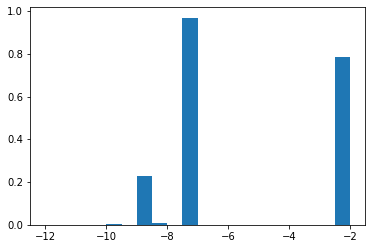

In [19]:
plt.hist(np.log(np.array(ls_list)), density = True, weights = np.array(w_list), bins = 20)


(array([6.88959755e-280, 3.82019648e-058, 1.72936781e-029, 3.42493833e-014,
        2.58236557e-006, 2.36362636e-001, 7.89533833e-001, 7.29795888e-003,
        9.70843439e-001, 2.45732415e-004, 5.77217187e-005, 1.07168356e-003,
        2.93208541e-007, 6.47407147e-006, 4.79049952e-011, 1.51806116e-009,
        3.70199059e-009, 9.74328591e-014, 3.77292771e-012, 5.11222141e-016]),
 array([ 5.01542621,  5.51407429,  6.01272237,  6.51137044,  7.01001852,
         7.50866659,  8.00731467,  8.50596274,  9.00461082,  9.50325889,
        10.00190697, 10.50055504, 10.99920312, 11.49785119, 11.99649927,
        12.49514735, 12.99379542, 13.4924435 , 13.99109157, 14.48973965,
        14.98838772]),
 <BarContainer object of 20 artists>)

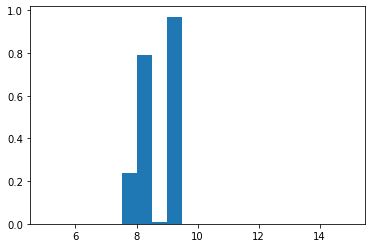

In [20]:
plt.hist(np.array(sg_list), density = True, weights = np.array(w_list), bins = 20)


(array([4.05994021e-01, 5.28426069e-06, 3.10466773e-03, 1.20985973e-02,
        3.53954243e-04, 2.02248557e-03, 3.94540877e+01, 7.60173699e-06,
        4.04905981e-04, 2.14580925e-03, 1.16589789e-02, 4.85636764e+01,
        2.76202173e-01, 7.40281810e-03, 1.94080140e-06, 1.15497920e+01,
        9.70121881e-05, 5.81090988e-04, 2.73452369e-02, 3.00881012e-06]),
 array([0.05022093, 0.06018933, 0.07015773, 0.08012613, 0.09009454,
        0.10006294, 0.11003134, 0.11999974, 0.12996814, 0.13993654,
        0.14990495, 0.15987335, 0.16984175, 0.17981015, 0.18977855,
        0.19974695, 0.20971536, 0.21968376, 0.22965216, 0.23962056,
        0.24958896]),
 <BarContainer object of 20 artists>)

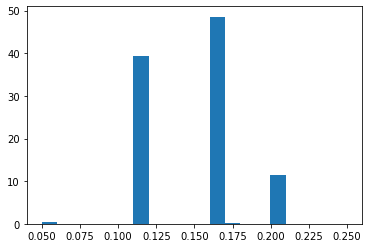

In [21]:
plt.hist(np.array(rate_list), density = True, weights = np.array(w_list), bins = 20)

(array([2.32658445e-03, 1.21893062e-06, 8.11309093e-07, 2.72362033e-03,
        7.04012368e-02, 2.14157613e-06, 1.55498254e-03, 2.72267049e-05,
        2.05416186e-05, 6.54231693e-02, 5.23896197e-06, 2.30711421e+00,
        5.57626976e-03, 7.88125487e+00, 6.01717398e-04, 9.70076227e+00,
        3.88106727e-04, 8.95664492e-06, 4.68222483e-04, 8.15445170e-06]),
 array([0.00146195, 0.05136546, 0.10126898, 0.15117249, 0.201076  ,
        0.25097951, 0.30088303, 0.35078654, 0.40069005, 0.45059356,
        0.50049708, 0.55040059, 0.6003041 , 0.65020762, 0.70011113,
        0.75001464, 0.79991815, 0.84982167, 0.89972518, 0.94962869,
        0.9995322 ]),
 <BarContainer object of 20 artists>)

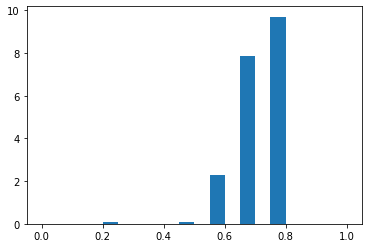

In [22]:
plt.hist(np.array(p_fw_list), density = True, weights = np.array(w_list), bins = 20)

In [23]:
np.argmax(w_list)

331

In [32]:
true_bp = (1.0-np.mean(obs_sample == np.array(list(germline)), axis = 0))
colocals = get_colocal(obs_sample, germline,true_bp, 50)

mode_params = { "base_rate" : rate_list[331],
                       "lengthscale" : ls_list[331],
                       "gp_sigma" : sg_list[331],
                       "gp_ridge" : .01,
            "gp_offset": -10.0,
            "p_fw": p_fw_list[331]
            }
mode_params

{'base_rate': 0.16381852250388376,
 'lengthscale': 0.000593085156411419,
 'gp_sigma': 9.366777419487736,
 'gp_ridge': 0.01,
 'gp_offset': -10.0,
 'p_fw': 0.7841172399077955}

In [33]:
true_model_params

{'base_rate': 0.09040739452552618,
 'lengthscale': 8.698546135314927e-05,
 'gp_sigma': 8.600008858807978,
 'gp_ridge': 0.01,
 'gp_offset': -10,
 'p_fw': 0.676885499942337}

0
10
20
30
40
50
60
70
80
90


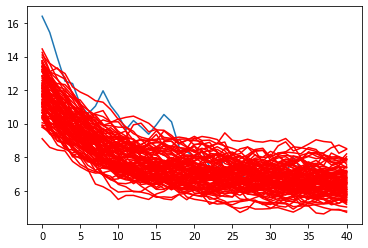

In [34]:
plt.plot(np.convolve(colocals, np.ones(10)/10, mode='valid'))
resamples = []
resamp_colocals = []
for i in range(100):
    mode_sample = gen_batch_letters(germline, 1000, mode_params)
    mode_bp = (1.0-np.mean(mode_sample == np.array(list(germline)), axis = 0))
    mode_colocals = get_colocal(mode_sample, germline,mode_bp, 50)
    resamples.append(mode_sample)
    resamp_colocals.append(mode_colocals)
    plt.plot(np.convolve(mode_colocals, np.ones(10)/10, mode='valid'), color = 'red')
    if i %10 == 0:
        print(i)
plt.show()


0
10
20
30
40
50
60
70
80
90


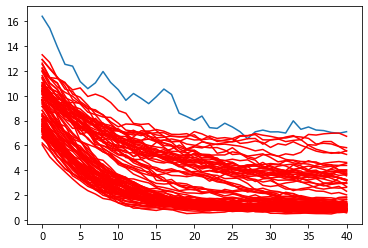

In [36]:
plt.plot(np.convolve(colocals, np.ones(10)/10, mode='valid'))
resamples = []
resamp_colocals = []
for i in range(100):
    mode_params['lengthscale']  = np.random.uniform(low = -12.0, high = -2.0)
    mode_sample = gen_batch_letters(germline, 1000, mode_params)
    mode_bp = (1.0-np.mean(mode_sample == np.array(list(germline)), axis = 0))
    mode_colocals = get_colocal(mode_sample, germline,mode_bp, 50)
    resamples.append(mode_sample)
    resamp_colocals.append(mode_colocals)
    plt.plot(np.convolve(mode_colocals, np.ones(10)/10, mode='valid'), color = 'red')
    if i %10 == 0:
        print(i)
plt.show()

In [27]:
nns = [i[0] for i in resamp_colocals]
total_muts = [np.sum(i != np.array(list(germline))) for i in resamples]

(array([ 1.,  1.,  3.,  2.,  5.,  6., 10.,  5.,  8.,  6.,  7.,  4., 18.,
         8.,  2.,  3.,  5.,  1.,  3.,  2.]),
 array([1141.  , 1159.25, 1177.5 , 1195.75, 1214.  , 1232.25, 1250.5 ,
        1268.75, 1287.  , 1305.25, 1323.5 , 1341.75, 1360.  , 1378.25,
        1396.5 , 1414.75, 1433.  , 1451.25, 1469.5 , 1487.75, 1506.  ]),
 <BarContainer object of 20 artists>)

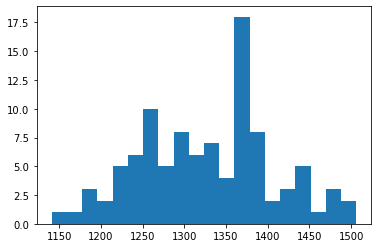

In [28]:
plt.hist(total_muts, bins = 20)

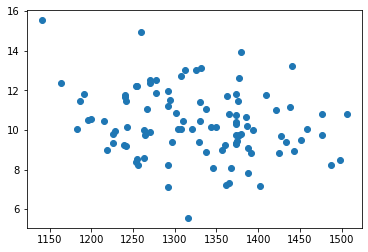

In [29]:
plt.scatter(total_muts,nns)

In [30]:
plt.plot(m_per_site)

NameError: name 'm_per_site' is not defined

In [ ]:
plt.plot(np.convolve(colocals, np.ones(10)/10, mode='valid'))
for i in range(100):
    mode_sample = gen_batch_letters(germline, 5000, mode_params)
    mode_bp = (1.0-np.mean(mode_sample == np.array(list(germline)), axis = 0))
    mode_colocals = get_colocal(mode_sample, germline,mode_bp, 50)
    plt.plot(np.convolve(mode_colocals, np.ones(10)/10, mode='valid'), color = 'red')
    if i %10 == 0:
        print(i)
plt.show()

In [ ]:
plt.plot(np.convolve(colocals, np.ones(10)/10, mode='valid'))
for i in range(40):
    mode_sample = gen_batch_letters(germline, 20000, mode_params)
    mode_bp = (1.0-np.mean(mode_sample == np.array(list(germline)), axis = 0))
    mode_colocals = get_colocal(mode_sample, germline,mode_bp, 50)
    plt.plot(np.convolve(mode_colocals, np.ones(10)/10, mode='valid'), color = 'red')
    if i %10 == 0:
        print(i)
plt.show()

In [ ]:
plt.show()

In [ ]:
plt.plot(np.convolve(colocals, np.ones(10)/10, mode='valid'))
resamples = []
resamp_colocals = []
for i in range(100):
    mode_sample = gen_batch_letters(germline, 1000, mode_params)
    mode_bp = (1.0-np.mean(mode_sample == np.array(list(germline)), axis = 0))
    mode_colocals = get_colocal(mode_sample, germline,mode_bp, 50)
    resamples.append(mode_sample)
    resamp_colocals.append(mode_colocals)
    plt.plot(np.convolve(mode_colocals, np.ones(10)/10, mode='valid'), color = 'red')
    if i %10 == 0:
        print(i)
plt.show()